In [1]:
import json
import numpy as np
import torch
from data_loader.data_loaders import FeatureDataset, feature_collate_fn
from utils import BatchKNearestNeighbor

# Load data
dataset = FeatureDataset('data/generated/')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=3000, shuffle=False, num_workers=0, collate_fn=feature_collate_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_features = torch.load('./data/coco/gallery/features/resnet50_features.pt')
all_img_features = torch.stack(list(all_features.values()))
all_img_ids = np.array(list(all_features.keys()))

nbrs = BatchKNearestNeighbor(batch_size=5000, device=device, mask=True)
nbrs.fit(all_img_features.view(all_img_features.shape[0], -1).cpu().numpy())
index = 0
queries = []
query_ids = []
query_features = []
for i, (img_ids, features, layouts) in enumerate(dataloader):
    query_features = np.stack(features, axis=0)
    batch_size = len(features)
    indices, distance = nbrs.predict(query_features, k=10)
    print(query_features.reshape(batch_size, 2048, 7, 7))

    if i == index:
        queries = layouts
        query_features = features
        query_ids = img_ids
        break



: 

In [58]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

query_idx = 135
# draw a 31 x 31 empty grid
l = 300
grid = np.zeros((l, l, 3))
# draw the bounding box
for i in range(len(queries[query_idx])):
    x, y, w, h = queries[query_idx][i]['bbox']
    x, y, w, h = l * x, l * y, l * w, l * h
    x_min, y_min = int(x - w / 2), int(y - h / 2)
    x_max, y_max = math.ceil(x + w / 2), math.ceil(y + h / 2)
    cv2.rectangle(grid, (x_min, y_min), (x_max, y_max), (1, 1, 1), 1)
    text = f'{queries[query_idx][i]["category"]}'
    cv2.putText(grid, text, (x_min+5, y_min+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (1, 1, 1), 1)

# draw edge around the grid.
grid[0, :, :] = 1
grid[-1, :, :] = 1
grid[:, 0, :] = 1
grid[:, -1, :] = 1

grid = 1 - grid
# plt.imshow(grid)
# plt.axis('off')
# plt.show()
print(len(dataset))

3097


193808
193808


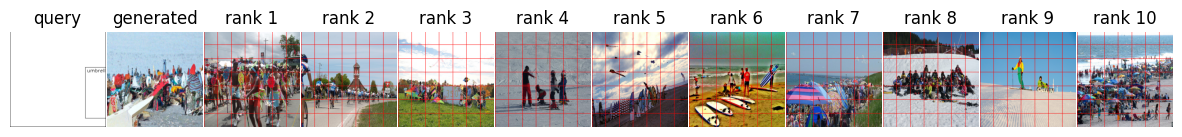

In [61]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

query_idx = 149
print(img_ids[query_idx])
# draw a 31 x 31 empty grid
l = 300
grid = np.zeros((l, l, 3))
# draw the bounding box
for i in range(len(queries[query_idx])):
    x, y, w, h = queries[query_idx][i]['bbox']
    x, y, w, h = l * x, l * y, l * w, l * h
    x_min, y_min = int(x - w / 2), int(y - h / 2)
    x_max, y_max = math.ceil(x + w / 2), math.ceil(y + h / 2)
    cv2.rectangle(grid, (x_min, y_min), (x_max, y_max), (1, 1, 1), 1)
    text = f'{queries[query_idx][i]["category"]}'
    cv2.putText(grid, text, (x_min+5, y_min+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (1, 1, 1), 1)

# draw edge around the grid.
grid[0, :, :] = 1
grid[-1, :, :] = 1
grid[:, 0, :] = 1
grid[:, -1, :] = 1

grid = 1 - grid
# ranked_list = all_img_ids[indices[query_idx]]
ranked_list = all_img_ids[indices[query_idx]]
# relevant_positions = [idx for idx, img in enumerate(ranked_list) if is_relevant(queries[query_idx], img, coco=coco)]
# img_paths = [f'./data/coco/val2017/images/000000{all_img_ids[indices[query_idx][i]]:06}.jpg' for i in range(20)]
img_paths = [f'./data/coco/gallery/images/000000{all_img_ids[indices[query_idx][i]]:06}.jpg' for i in range(10)]

generated_img = Image.open(f'./data/generated/images/{query_ids[query_idx]:012}_0.png')
# img_path = f'./data/coco/val2017/images/000000221281.jpg'
print(query_ids[query_idx])

TARGET_SIZE = (256, 256)  # Adjust as needed

plt.figure(figsize=(15, 10))

# Display the 'query' image in the first position
plt.subplot(2, 12, 1) # for 1 row and 11 columns (1 query + 10 results)
plt.imshow(grid)
plt.axis('off')
plt.title('query')

# Display 'generated image' in the second position
plt.subplot(2, 12, 2) # for 1 row and 11 columns (1 query + 10 results)
plt.imshow(generated_img)
plt.axis('off')
plt.title('generated')
# Loop through and display 10 result images
for i in range(10):
    plt.subplot(2, 12, i+3) # for 1 row and 11 columns
    img = Image.open(img_paths[i])
    
    # Resize the image to target size
    img = img.resize(TARGET_SIZE, Image.LANCZOS)

    draw = ImageDraw.Draw(img)
    width, height = img.size
    x_spacing = width / 7
    y_spacing = height / 7
    
    # Draw grid lines
    for j in range(8):
        x = int(x_spacing * j)
        draw.line([(x, 0), (x, height)], fill='red')
    for j in range(8):
        y = int(y_spacing * j)
        draw.line([(0, y), (width, y)], fill='red')
    
    # Draw a light green border for relevant positions
    # if i in relevant_positions:
    #     draw.rectangle([(0, 0), (width, height)], outline='lightgreen', width=7)

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    # plt.title(f'rank {i+1}, img: {all_img_ids[indices[query_idx][i]]}, distance: {distances[query_idx][i]:.3f}')
    plt.title(f'rank {i+1}')

plt.subplots_adjust(wspace=0.02, hspace=0)
plt.show()



In [5]:
all_features = torch.load('./data/coco/val2017/features/resnet50_features.pt')
all_img_features = torch.stack(list(all_features.values()))
all_img_ids = np.array(list(all_features.keys()))

In [59]:
from model.model import ResNet50
from PIL import Image, ImageDraw
from utils import create_bbox_mask
import torch, torchvision
import matplotlib.pyplot as plt

device='cuda'
model = ResNet50(pretrained=True)
model = model.to(device)

real_idx = 7
query_idx = idx_list[real_idx]
img_path = img_list[real_idx]
print(query_idx, img_path)
img = Image.open(img_path)
img = torchvision.transforms.Resize((224, 224))(img)
img_tensor = torchvision.transforms.ToTensor()(img)
img_tensor = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_tensor).to(device)
model.eval()
feature = model(img_tensor.unsqueeze(0))
masks = torch.stack([create_bbox_mask(query_dict[query_idx][k]['bbox'], 7) for k in range(len(query_dict[query_idx]))]).unsqueeze(1).to(device)
feature = feature * masks
feature = feature.detach().cpu().numpy()
feature = feature.reshape(feature.shape[0], -1)



429530 ./sample/429530_vase.png


In [9]:
from utils import BatchKNearestNeighbor
nbrs = BatchKNearestNeighbor(batch_size=5000, device=device, mask=True)
nbrs.fit(all_img_features.view(all_img_features.shape[0], -1).numpy())

In [60]:
indices, distances = nbrs.predict(feature, k=20)
indices
all_img_ids[indices[0]]

array([407403, 376478, 132375, 231237, 140439, 550426, 167240, 453040,
       530457, 557884, 429530, 569700, 578922,  79034, 168458, 555972,
       577735, 395343, 344909, 144784])

1


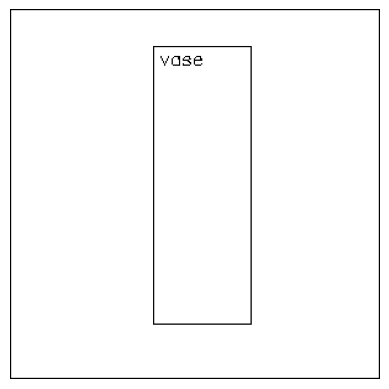

In [61]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math


# draw a 31 x 31 empty grid
l = 300
grid = np.zeros((l, l, 3))
# draw the bounding box
print(len(query_dict[query_idx]))
for i in range(len(query_dict[query_idx])):
    x, y, w, h = query_dict[query_idx][i]['bbox']
    x, y, w, h = l * x, l * y, l * w, l * h
    x_min, y_min = int(x - w / 2), int(y - h / 2)
    x_max, y_max = math.ceil(x + w / 2), math.ceil(y + h / 2)
    cv2.rectangle(grid, (x_min, y_min), (x_max, y_max), (1, 1, 1), 1)
    text = f'{query_dict[query_idx][i]["category"]}'
    cv2.putText(grid, text, (x_min+5, y_min+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (1, 1, 1), 1)

# draw edge around the grid.
grid[0, :, :] = 1
grid[-1, :, :] = 1
grid[:, 0, :] = 1
grid[:, -1, :] = 1

grid = 1 - grid
plt.imshow(grid)
plt.axis('off')
plt.show()



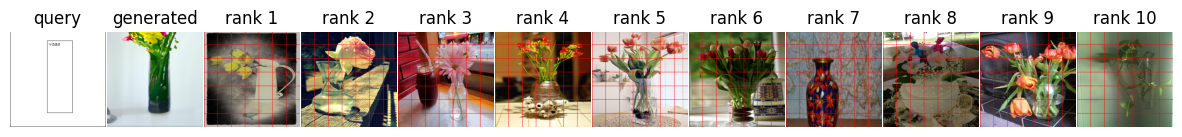

In [62]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# ranked_list = all_img_ids[indices[query_idx]]
ranked_list = all_img_ids[indices[0]]
# relevant_positions = [idx for idx, img in enumerate(ranked_list) if is_relevant(queries[query_idx], img, coco=coco)]
img_paths = [f'./data/coco/val2017/images/000000{all_img_ids[indices[0]][i]:06}.jpg' for i in range(10)]
# img_paths = [f'./data/coco/gallery/images/000000{all_img_ids[indices[query_idx][i]]:06}.jpg' for i in range(10)]
generated_img = Image.open(img_path)
# img_path = f'./data/coco/val2017/images/000000221281.jpg'
# print(query_ids[query_idx])

TARGET_SIZE = (256, 256)  # Adjust as needed

plt.figure(figsize=(15, 10))

# Display the 'query' image in the first position
plt.subplot(2, 12, 1) # for 1 row and 11 columns (1 query + 10 results)
plt.imshow(grid)
plt.axis('off')
plt.title('query')

# Display 'generated image' in the second position
plt.subplot(2, 12, 2) # for 1 row and 11 columns (1 query + 10 results)
plt.imshow(generated_img)
plt.axis('off')
plt.title('generated')

# Loop through and display 10 result images
for i in range(10):
    plt.subplot(2, 12, i+3) # for 1 row and 11 columns
    img = Image.open(img_paths[i])
    
    # Resize the image to target size
    img = img.resize(TARGET_SIZE, Image.LANCZOS)

    draw = ImageDraw.Draw(img)
    width, height = img.size
    x_spacing = width / 7
    y_spacing = height / 7
    
    # Draw grid lines
    for j in range(8):
        x = int(x_spacing * j)
        draw.line([(x, 0), (x, height)], fill='red')
    for j in range(8):
        y = int(y_spacing * j)
        draw.line([(0, y), (width, y)], fill='red')
    
    # Draw a light green border for relevant positions
    # if i in relevant_positions:
    #     draw.rectangle([(0, 0), (width, height)], outline='lightgreen', width=7)

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    # plt.title(f'rank {i+1}, img: {all_img_ids[indices[query_idx][i]]}, distance: {distances[query_idx][i]:.3f}')
    plt.title(f'rank {i+1}')

plt.subplots_adjust(wspace=0.02, hspace=0)
plt.show()



In [59]:
tmp_features = torch.load('./data/generated/features/resnet50_features.pt')
print(len(tmp_features.keys()))



3097
